In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import RobertaModel, RobertaTokenizer

import os
import random

In [4]:
datasets_path = os.path.join(os.getcwd(),"datasets","iemocap_text")

df = pd.DataFrame()

for dataset in os.listdir(datasets_path):
    path = os.path.join(datasets_path,dataset)
    df = pd.concat([df,pd.read_csv(path)])

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [3]:
df = df[["Clip_Name","text","Label","Use"]]
df = df.dropna()

KeyError: "None of [Index(['Clip_Name', 'text', 'Label', 'Use'], dtype='object')] are in the [columns]"

In [4]:
labelEncoder = {"Negative" : 0, "Neutral" : 1, "Positive" : 2}

df["Label"] = [labelEncoder[label] for label in df["Label"]]

In [5]:
df

,Clip_Name,text,Label,Use
0,Ses02F_impro01_F000,"Hi. Excuse me. Um, I'd like to put in this app...",1,train
1,Ses02F_impro01_F018,"Well, why didn't the D.M.V. put that you neede...",0,test
2,Ses02F_impro01_F019,"Yeah, but your birth certificate--I mean, who ...",0,train
3,Ses02F_impro01_F020,With your driver's license and your passport. ...,0,train
4,Ses02F_impro01_F021,Who--you always use your driver's license. I m...,0,train
...,...,...,...,...
580,Ses03M_script03_2_M040,Turn it--Turn it off.,0,train
581,Ses03M_script03_2_M041,Very amusing indeed.,0,train
582,Ses03M_script03_2_M042,"You know what? You're a vile, little, evil-min...",0,train
583,Ses03M_script03_2_M043,You're not going nowhere. No you're not.,0,train


In [6]:
SEED = 19

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
else: 
    device = torch.device("cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

GeForce GTX 1080 Ti


In [7]:
train_data = df[df["Use"] == "train"]
val_data = df[df["Use"] == "validation"]
test_data = df[df["Use"] == "test"]

In [8]:
MODEL_NAME = 'roberta-base'

In [9]:
bert = RobertaModel.from_pretrained(MODEL_NAME)

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [10]:
train_text = train_data["text"].tolist()
val_text = val_data["text"].tolist()
test_text = test_data["text"].tolist()

<AxesSubplot:>

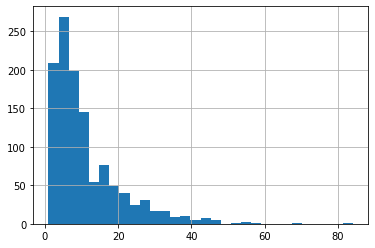

In [11]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [12]:
MAX_LEN = 30

tokens_train = tokenizer.batch_encode_plus(
    train_data["text"].tolist(),
    max_length = MAX_LEN,
    pad_to_max_length = True,
    truncation = True
)

tokens_val = tokenizer.batch_encode_plus(
    val_data["text"].tolist(),
    max_length = MAX_LEN,
    pad_to_max_length = True,
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    test_data["text"].tolist(),
    max_length = MAX_LEN,
    pad_to_max_length = True,
    truncation = True
)

/home/park/Workspace/MultiModal/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_data["Label"].tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_data["Label"].tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_data["Label"].tolist())

In [14]:
print(len(train_seq[0]))
print(len(test_y))

30
378


In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataset = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler = train_sampler, batch_size = batch_size)

val_dataset = TensorDataset(val_seq, val_mask, val_y)
val_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler = val_sampler, batch_size = batch_size)

test_dataset = TensorDataset(test_seq, test_mask, test_y)
test_sampler = RandomSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler = test_sampler, batch_size = batch_size)

In [16]:
class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert
        
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,3)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, sent_id, mask):
        
        ret = self.bert(sent_id, attention_mask = mask).pooler_output
#         ret = self.bert(sent_id, attention_mask = mask)
        
#         print(ret)
        
        x = self.fc1(ret)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
#         print(x.size())
        return x

In [17]:
model = BERT_Arch(bert)

model = model.to(device)

In [18]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-5)

In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train_data["Label"].tolist()), train_data["Label"].tolist())

print("class Weight : ",class_weights)

class Weight :  [0.64360242 1.17670683 1.67668097]


/home/park/Workspace/MultiModal/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,

In [20]:
# weights = torch.tensor(class_weights, dtype = torch.float)
# weights = weights.to(device)

cross_entropy = nn.NLLLoss()
epochs = 10

In [21]:
def train():
    model.train()
    
    total_loss, total_acc = 0, 0
    
    total_preds = []
    
    for step, batch in enumerate(train_dataloader):
        
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
        
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        
        model.zero_grad()
        preds = model(sent_id, mask)
        
        # how can i to draw graph using loss?
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        preds = preds.detach().cpu().numpy()
        
        total_preds.append(preds)
    
    avg_loss = total_loss / len(train_dataloader)
    
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds
    

In [22]:
def evaluate():
    print("\n Evaluating...")
    
    model.eval()
    
    total_loss, total_acc = 0, 0
    
    total_preds = []
    
    for step, batch in enumerate(val_dataloader):
        
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}'.format(step, len(val_dataloader)))
            
        batch = [t.to(device) for t in batch]
        
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            preds = preds.detach().cpu().numpy()
            
            total_preds.append(preds)
            
    avg_loss = total_loss / len(val_dataloader)
    
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds
    

In [23]:
best_valid_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(epochs):
    
    print('\n Epoch{:} / {:}'.format(epoch + 1, epochs))
    
    train_loss, _ = train()
    
    val_loss, _ = evaluate()
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'models/emocap_3class_rbt_Test.pt')
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Test Loss: {val_loss:.3f}')


 Epoch1 / 10

 Evaluating...

Training Loss: 1.077
Test Loss: 1.038

 Epoch2 / 10

 Evaluating...

Training Loss: 1.019
Test Loss: 0.994

 Epoch3 / 10

 Evaluating...

Training Loss: 0.997
Test Loss: 0.964

 Epoch4 / 10

 Evaluating...

Training Loss: 0.951
Test Loss: 0.913

 Epoch5 / 10

 Evaluating...

Training Loss: 0.857
Test Loss: 0.869

 Epoch6 / 10

 Evaluating...

Training Loss: 0.755
Test Loss: 0.861

 Epoch7 / 10

 Evaluating...

Training Loss: 0.663
Test Loss: 0.819

 Epoch8 / 10

 Evaluating...

Training Loss: 0.564
Test Loss: 0.855

 Epoch9 / 10

 Evaluating...

Training Loss: 0.497
Test Loss: 0.900

 Epoch10 / 10

 Evaluating...

Training Loss: 0.410
Test Loss: 0.885


In [25]:
path = 'models/emocap_3class_rbt_Test.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [31]:
with torch.no_grad():
    preds = model(val_seq.to(device),val_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [32]:
preds = np.argmax(preds, axis = 1)
print(classification_report(val_y,preds))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       198
           1       0.55      0.59      0.57        99
           2       0.65      0.42      0.51        77

    accuracy                           0.66       374
   macro avg       0.64      0.60      0.61       374
weighted avg       0.66      0.66      0.66       374



In [50]:
testDf = pd.read_csv(os.path.join(os.getcwd(),"datasets","session1_master.csv"))

In [51]:
testDf = testDf[testDf["Use"] ==  "test"]

In [52]:
testDf = testDf[["Clip_Name","text","Label"]]

In [53]:
testDf["Label"] = [labelEncoder[label] for label in testDf["Label"]]

In [54]:
tokens_test = tokenizer.batch_encode_plus(
    testDf["text"].tolist(),
    max_length = MAX_LEN,
    pad_to_max_length = True,
    truncation = True
)

In [55]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(testDf["Label"].tolist())

In [56]:
with torch.no_grad():
    preds = model(test_seq.to(device),test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [57]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y,preds))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        84
           1       0.52      0.63      0.57        46
           2       0.58      0.26      0.36        27

    accuracy                           0.63       157
   macro avg       0.60      0.55      0.55       157
weighted avg       0.63      0.63      0.62       157

